In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

from pymoo.optimize import minimize as minimize_pymoo
from pymoo.problems.functional import FunctionalProblem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.config import Config
Config.warnings['not_compiled'] = False

**Complex Reactions with Heat Effects in a PFR**

You can download Fogler's book from here: https://doku.pub/download/h-scott-fogler-essentials-of-chemical-reaction-engineering-z0x2ze484wqn

$A + 2B → C$\
$2A + 3C → D$

In [2]:
# molar rates
Fa0 = 5 # mol/min
Fb0 = 2*Fa0 # mol/min since the feed is stoichiometric (A+2B->C) and FA0 is 5 mol/min
Fc0 = 0 # mol/min
Fd0 = 0 # mol/min
Fi0 = np.array([Fa0, Fb0, Fc0, Fd0])

# initial concentration
Ct0 = 0.2 # mol/dm3

# entering pressure
P = 100 # atm
yp = 1  # no pressure drop

# reaction enthalpies
dHr1B = -15000 # cal/mol B
dHr2A = -10000 # cal/mol A
T0 = 300
    
Ea1 = 8000 # cal/mol
K1a0 = 40
Ea2 = 12000 # cal/mol
k2a0 = 2
R = 1.987 # cal/mol/K

Cpa = 10 # cal/mol/K
Cpb = 12 # cal/mol/K
Cpc = 14 # cal/mol/K
Cpd = 16 # cal/mol/K
Cpi = np.array([10, 12, 14, 16]) # cal/mol/K

Ua = 80 # cal/min/K
Ta0 = 325 # K
m = 50 # mol/min
Cp_cool = 10 # cal/mol/K is the heat capacity of th coolant fluid

V = 10 # dm3

Text(0.5, 1.0, 'Co-current heat exchange')

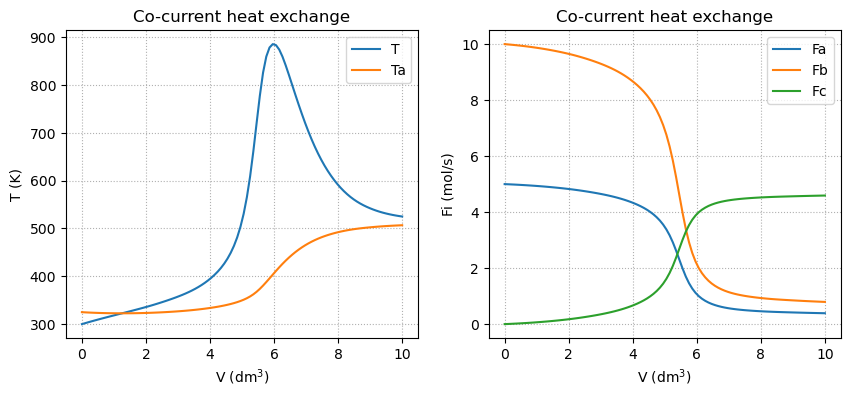

In [3]:
a, b, c, d = np.arange(4)

def arr(k1, Ea, T):
    
    return k1*np.exp((Ea/R)*(1/300-1/T))

def odes(x, y, *params):
    
    Ct0, T0, yp, K1a0, Ea1, k2a0, Ea2, dHr1B, dHr2A, Ua, Cpi, m, Cp_cool = params 
    
    F = y[:-2]
    T = y[-2]
    Ta = y[-1]
    
    C = Ct0*(F/F.sum())*(T0/T)*yp
    
    k1a = arr(K1a0, Ea1, T)
    k2c = arr(k2a0, Ea2, T)
    
    # elementary rate laws
    r1a = -k1a*C[a]*C[b]**2
    r2c = -k2c*C[a]**2*C[c]**3
    
    # relative rates based on stoichiometry of the reaction A+2B->C & 2A+3C->D
    r1b = 2*r1a
    r1c = -r1a
    r2a = (2/3)*r2c
    r2d = -(1/3)*r2c
    
    # net rates - always the sum of relative rates
    ra = r1a + r2a
    rb = r1b
    rc = r1c + r2c
    rd = r2d

    # mass balance
    rates = np.array([ra, rb, rc, rd])
    dF = rates
    
    # energy balance T
    Qg = r1b*dHr1B + r2a*dHr2A # "Heat Generated" term
    Qr = Ua*(T-Ta) # "Heat Removed" term
    sumFiCpi = (F*Cpi).sum()
    dT = (Qg-Qr)/sumFiCpi
    
    # energy balance Ta
    dTa = Ua*(T-Ta)/m/Cp_cool
    
    return np.hstack((dF, dT, dTa))
       
y0 = np.hstack((Fi0, T0, Ta0))

sol = solve_ivp(odes, (0, V), y0, t_eval = np.linspace(0, V, 100),
               args = (Ct0, T0, yp, K1a0, Ea1, k2a0, Ea2, dHr1B, dHr2A, Ua, Cpi, m, Cp_cool))

fig, ax = plt.subplots(ncols = 2, figsize = (10, 4), dpi = 100)


ax[0].set_ylabel("T (K)")
ax[0].set_xlabel("V (dm$^3$)")
ax[0].plot(sol.t, sol.y[4])
ax[0].plot(sol.t, sol.y[5])
ax[0].legend(['T', 'Ta'])
ax[0].grid(linestyle= ':')
ax[0].set_title('Co-current heat exchange')

for yi in sol.y[:-3]:
    ax[1].plot(sol.t, yi)

ax[1].set_ylabel("Fi (mol/s)")
ax[1].set_xlabel("V (dm$^3$)")
ax[1].legend(['Fa', 'Fb', 'Fc'])
ax[1].grid(linestyle= ':')
ax[1].set_title('Co-current heat exchange')

### In addition to Fogler's example we are going to carry out a single & multi objective optimization to demonstrate the functionality of Scipy and Pymoo libraries.

Scipy is used exclusively for single-objective optimizations while on the other hand Pymoo can be used efficiently for both single and multi-objective purposes.

**Disclaimer**

*The purpose of this example is to demonstrate the functionality of **Scipy's "SLSQP"** and **Pymoo's "NSGA-II"** library for single & multi-objective problems. In essence, a well-grounded techno-economic analysis should also be realised to properly evaluate the results.*

### Single-Objective Optimization using Scipy

$Design~Variables: V, T(0), T_a(0)$

$Objective: F_C(V) - F_C(0)$

$Functional~constraint: T(W) \leq 495~or~495 -T(W) \geq0  $

$Variable~bounds: 0.1 \leq V \leq 10,~250 \leq T(0) \leq 800,  ~200 \leq T_a(0) \leq 800$

*Note that the functional constraint should be returned in the proper form (495 - T) in order to be used in scipy's minimize method*

In [31]:
def obj_conv(x):
    
    V = x[0]
    T0 = x[1]
    Ta0 = x[2]
    
    y0 = np.hstack((Fi0, T0, Ta0))
    
    sol = solve_ivp(odes, (0, V), y0,
                   args = (Ct0, T0, yp, K1a0, Ea1, k2a0, Ea2, dHr1B, dHr2A, Ua, Cpi, m, Cp_cool))
    
    y = sol.y[:, -1]
    F = y[:-2] # while T = y[-2] and Ta = y[-1]
    
    Fa = (F[0] - Fi0[0])
    Fb = (F[1] - Fi0[1])
    Fc = (F[2] - Fi0[2])
    Fd = (F[3] - Fi0[3])
     
    return  -Fc


def cons_func(x):
    
    V = x[0]
    T0 = x[1]
    Ta0 = x[2]
    
    y0 = np.hstack((Fi0, T0, Ta0))
    
    sol = solve_ivp(odes, (0, V), y0,
                   args = (Ct0, T0, yp, K1a0, Ea1, k2a0, Ea2, dHr1B, dHr2A, Ua, Cpi, m, Cp_cool))
    
    y = sol.y[:, -1]
    T = y[-2]
    
    return  495 - T

bounds = [(0.001, 10), (250, 800), (200, 800)]

sol_constrained = minimize(obj_conv, np.array([5, 300, 300]), method="SLSQP", bounds=bounds,
                           constraints={"fun":cons_func, "type":"ineq"})

In [32]:
sol_constrained

     fun: -0.9400843301664077
     jac: array([-2.04651058e-03, -2.53684819e-04, -7.55190849e-05])
 message: 'Optimization terminated successfully'
    nfev: 89
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([  4.27282586, 383.4121612 , 252.11976278])

In [33]:
sol_constrained.x

array([  4.27282586, 383.4121612 , 252.11976278])

In [34]:
def ode_from_opt(x, t_eval=None):
    
    V = x[0]
    T0 = x[1]
    Ta0 = x[2]
    
    y0 = np.hstack((Fi0, T0, Ta0))
    
    sol = solve_ivp(odes, (0, V), y0, t_eval = np.linspace(0, V, 100),
                   args = (Ct0, T0, yp, K1a0, Ea1, k2a0, Ea2, dHr1B, dHr2A, Ua, Cpi, m, Cp_cool))
    
    return sol

sol_ode_constrained = ode_from_opt(sol_constrained.x, t_eval=np.linspace(0, sol_constrained.x[0], 200))

Text(0.5, 1.0, 'Co-current heat exchange - Optimized')

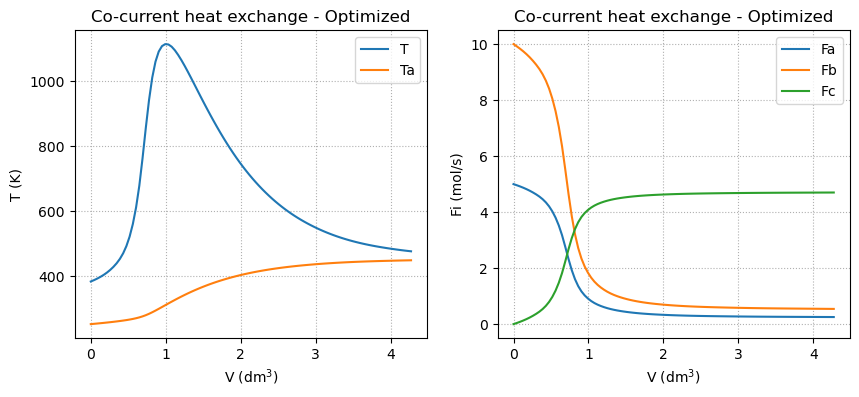

In [35]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4), dpi = 100)


ax[0].set_ylabel("T (K)")
ax[0].set_xlabel("V (dm$^3$)")
ax[0].plot(sol_ode_constrained.t, sol_ode_constrained.y[4])
ax[0].plot(sol_ode_constrained.t, sol_ode_constrained.y[5])
ax[0].legend(['T', 'Ta'])
ax[0].grid(linestyle= ':')
ax[0].set_title('Co-current heat exchange - Optimized')

for yi in sol_ode_constrained.y[:-3]:
    ax[1].plot(sol_ode_constrained.t, yi)

ax[1].set_ylabel("Fi (mol/s)")
ax[1].set_xlabel("V (dm$^3$)")
ax[1].legend(['Fa', 'Fb', 'Fc'])
ax[1].grid(linestyle= ':')
ax[1].set_title('Co-current heat exchange - Optimized')

### Multi-Objective Optimization using Pymoo

$Design~Variables: V, T(0), T_a(0)$

$Objective~(1): ~F_C(V) - F_C(0)$

$Objective~(2): ~F_D(V) - F_D(0)$

$Functional~constraint: T(W) \leq 495~or~T(W) - 495 \geq0  $

$Variable~bounds: 0.1 \leq V \leq 10,~250 \leq T(0) \leq 800,  ~200 \leq T_a(0) \leq 800$

*Note that the functional constraint should be returned in the proper form (T - 495) in order to be used in pymoo's minimize method*

In [36]:
class MultiProblem(ElementwiseProblem):
    
    def __init__(self):
        
        xl = []
        xu = []
        
        for bound in bounds:
            xl.append(bound[0])
            xu.append(bound[1])
        
        super().__init__(n_var=3, n_obj=2, n_constr=1, xl=xl, xu=xu)
    
    def _evaluate(self, x, out, *args, **kwargs):
        
        V = x[0]
        T0 = x[1]
        Ta0 = x[2]

        y0 = np.hstack((Fi0, T0, Ta0))

        sol = solve_ivp(odes, (0, V), y0,
                       args = (Ct0, T0, yp, K1a0, Ea1, k2a0, Ea2, dHr1B, dHr2A, Ua, Cpi, m, Cp_cool))

        y = sol.y[:, -1]
        
        F = y[:-2]
        Fa = (F[0] - Fi0[0])
        Fb = (F[1] - Fi0[1])
        Fc = (F[2] - Fi0[2])
        Fd = (F[3] - Fi0[3])
        T = y[-2]
        
        out["F"] = - np.array([Fc, Fd])            
        out["G"] = np.array([T - 420]) 

In [37]:
problem = MultiProblem()

algorithm = NSGA2(pop_size=100)

res = minimize_pymoo(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.000000E+00 |  3.343055E+02 |             - |             -
     2 |      200 |      1 |  0.000000E+00 |  9.545607E+01 |  4.3340143801 |         ideal
     3 |      300 |      1 |  0.000000E+00 |  1.020786E+01 |  0.0004035541 |             f
     4 |      400 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0004035541 |             f
     5 |      500 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0004035541 |             f
     6 |      600 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0192361049 |         ideal
     7 |      700 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


C:\Users\Ambrosios\AppData\Local\Temp\ipykernel_8992\2136607771.py:5: RuntimeWarning: overflow encountered in exp
  return k1*np.exp((Ea/R)*(1/300-1/T))
C:\Users\Ambrosios\AppData\Local\Temp\ipykernel_8992\2136607771.py:33: RuntimeWarning: invalid value encountered in double_scalars
  rc = r1c + r2c


     8 |      800 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0080726113 |         ideal
     9 |      900 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0002236333 |             f
    10 |     1000 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0013327834 |             f
    11 |     1100 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0013327834 |             f
    12 |     1200 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0032924275 |         ideal
    13 |     1300 |      2 |  0.000000E+00 |  0.000000E+00 |  1.4780575493 |         ideal
    14 |     1400 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0030159332 |         nadir
    15 |     1500 |      2 |  0.000000E+00 |  0.000000E+00 |  1.1202531477 |         ideal
    16 |     1600 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0554094513 |         ideal
    17 |     1700 |      2 |  0.000000E+00 |  0.000000E+00 |  1.2680092262 |         ideal
    18 |     1800 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0155443121 |         ideal

    99 |     9900 |     98 |  0.000000E+00 |  0.000000E+00 |  0.0011732853 |             f
   100 |    10000 |     99 |  0.000000E+00 |  0.000000E+00 |  0.0014570344 |             f
   101 |    10100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0014967319 |             f
   102 |    10200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0085445997 |         ideal
   103 |    10300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0000940741 |             f
   104 |    10400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0002554438 |             f
   105 |    10500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0008328817 |             f
   106 |    10600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0008712702 |             f
   107 |    10700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0013621616 |             f
   108 |    10800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0018264726 |             f
   109 |    10900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0019882592 |             f

   190 |    19000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0012416942 |             f
   191 |    19100 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0013353408 |             f
   192 |    19200 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0013507453 |             f
   193 |    19300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0016632405 |             f
   194 |    19400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0017331024 |             f
   195 |    19500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0016270249 |             f
   196 |    19600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0016667827 |             f
   197 |    19700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0017692093 |             f
   198 |    19800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0018935961 |             f
   199 |    19900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0019641398 |             f
   200 |    20000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0019701616 |             f

In [38]:
res.X[-1]

array([ 10.        , 566.78161179, 200.17801103])

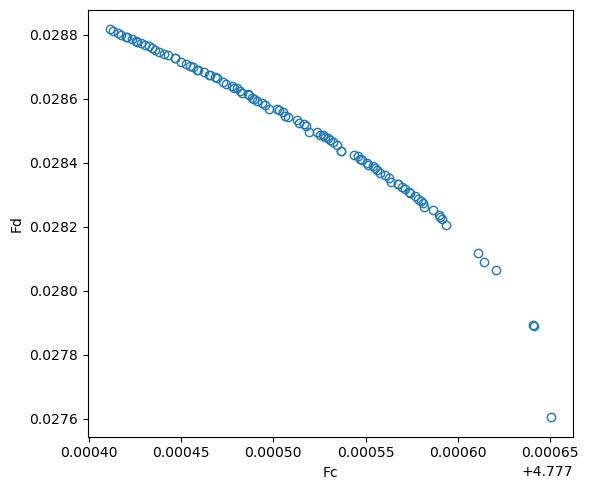

In [39]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)

df = pd.DataFrame()
df['Fc'] = -res.F[:, 0]
df['Fd'] = -res.F[:, 1]

ax.plot(df['Fc'], df['Fd'], 'o', mfc = 'none')
ax.set_xlabel('Fc')
ax.set_ylabel('Fd')

fig.tight_layout()

In [40]:
df.corr()

,Fc,Fd
Fc,1.000000,-0.972605
Fd,-0.972605,1.000000
